In [2]:
#Install tqdm library for progress bars
!pip install tqdm
!pip install seaborn

# The Activity Recognition Chain

In this notebook, we will explore the [activity recognition chain ](https://dl.acm.org/doi/10.1145/2499621)to identify user activities using wrist-worn accelerometer data.

## Before you begin
1. Recall the steps of the activity recognition chain from the paper. We will be using a simplified version for this workshop. Recall the meaning of metrics used to evaluate classification performance.

2. Read the whole notebook. This will give you an overview of where we are going.


## Introduction

Activity recognition is the process of automatically identifying and classifying human activities based on sensor data. It has a wide range of applications, including health monitoring, fitness tracking, context-aware computing, and more. Wrist-worn accelerometers are commonly used sensors for activity recognition, as they can capture the motion patterns of the human body.

In this notebook, we will work with the ADL Recognition with Wrist-worn Accelerometer Data Set. This dataset provides accelerometer recordings of various activities performed by 16 volunteers. The dataset includes a range of activities, such as walking, running, sitting, standing, climbing stairs, and more. Each activity has multiple recordings performed by the volunteers.

## Learning outcomes
By the end of this notebook, you will be able to implement an activity recognition chain in python.
You will get to know and use the libraries typically used: pandas for reading and manipulating data, tsfresh for feature extraction and scikit-learn for model building.

## Notebook Structure

*Reading the dataset and Exploratory Data Analysis* We will start by exploring the structure and contents of the ADL Recognition dataset. We will visualize activity distributions, analyze accelerometer signals, and explore patterns in the data.

*Feature Engineering:* Feature engineering is a crucial step in activity recognition. We will use tsfresh to obtain common statistical features. Read the documentation to get to know all the available features.

*Model Training and Evaluation:* In this section, we will train and evaluate an activity recognition model using the preprocessed dataset and extracted features. We will explore two different machine learning algorithms, such as support vector machines (SVM) and decision trees to build our model. We will evaluate the model's performance leave-one-subject-out cross-validation and common metrics (accuracy, f1-score, precision, recall).

During the notebook you will find **Activities**. Write your answers in a doc file and submit them in moodle.

Let's get started with the dataset overview! First we will import some libraries that we will use to process the data

In [3]:
import os
import zipfile
import pandas as pd
import numpy as np
from tqdm import tqdm #for progress bar

Download the dataset from https://archive.ics.uci.edu/static/public/283/dataset+for+adl+recognition+with+wrist+worn+accelerometer.zip. Name the file dataset.zip. Use the -q option to avoid output from wget command

In [4]:
#Download dataset from https://archive.ics.uci.edu/static/public/283/dataset+for+adl+recognition+with+wrist+worn+accelerometer.zip and store in a file called dataset.zip

#!wget https://archive.ics.uci.edu/static/public/283/dataset+for+adl+recognition+with+wrist+worn+accelerometer.zip -O adl_dataset -q

## Reading the Dataset

The ADL Recognition dataset is organized in a folder structure, where each activity has its own folder containing accelerometer recordings. The dataset follows a specific file naming convention: Accelerometer-[START_TIME]-[HMP]-[VOLUNTEER], where:

[START_TIME] represents the timestamp of the starting moment of the recording in the format YYYY-MM-DD-HH-MM-SS.

[HMP] is the name of the human motion pattern performed in the recorded trial.

[VOLUNTEER] is the identification code of the volunteer performing the recorded motion, following the format [gN], where 'g' indicates the gender of the volunteer (m -> male, f -> female), and 'N' indicates the progressive number associated with the volunteer.

The **read_file** function reads one file of the dataset while the **read_dataset** function reads the whole dataset, beginning with extracting all files from the zip folder.

Notice how the information is extracted from the filename and how the pandas DataFrame is created by concatening all files.


In [5]:
def read_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Remove trailing newline character
            line = line.rstrip('\n')
            # Split the line by space delimiter
            values = line.split(' ')
            # Convert the coded values to real acceleration values
            real_values = [(-1.5 + (int(val) / 63) * 3) for val in values]
            data.append(real_values)

    return pd.DataFrame(data, columns=['X', 'Y', 'Z'])


In [6]:
def read_dataset(zip_file_path, extracted_folder_path, sampling_frequency):

  # Create an empty DataFrame to store the dataset
  df = pd.DataFrame()

  # Extract the files from the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extracted_folder_path)

  # Iterate over all subdirectories inside the extracted folder
  id = 0
  for root, dirs, files in os.walk(extracted_folder_path):
      for directory in tqdm(dirs, total=len(dirs)):  #Notice the use of tqdm to show progress bars
          directory_path = os.path.join(root, directory)

          # Check if the directory contains files starting with "Accelerometer"
          if any(file.startswith('Accelerometer') for file in os.listdir(directory_path)):

              # Iterate over the files in the directory
              for filename in os.listdir(directory_path):
                  if filename.startswith('Accelerometer'):
                      file_path = os.path.join(directory_path, filename)

                      # Extract information from the file name
                      file_parts = filename.split('-')
                      start_time = '-'.join(file_parts[1:7])
                      volunteer = file_parts[-1].split('.')[0]
                      label = file_parts[7]

                      # Read the dataset from the file
                      dataset = read_file(file_path)

                      # Extract the start time from the filename
                      start_time = pd.to_datetime(start_time, format='%Y-%m-%d-%H-%M-%S')


                      # Calculate the time increment based on the sampling frequency
                      time_increment = pd.to_timedelta(1 / sampling_frequency, unit='s')

                      # Create a new column for the adjusted time
                      dataset['Time'] = start_time + (pd.to_timedelta(dataset.index* time_increment, unit='s') )


                      # Add the label, start time, and volunteer columns
                      dataset['Start_Time'] = start_time
                      dataset['Label'] = label
                      dataset['Volunteer'] = volunteer
                      dataset['id'] = id
                      id += 1

                      # Append the dataset to the DataFrame
                      df = pd.concat([df, dataset])
  return df

We have now created our two functions. Let's define values for the parameters, where the zip folder is located and where we want to extract the folder.  The sampling frequency will allow us to calculate the time of each datapoint.


In [7]:
import os

# Detect if running in Google Colab or VSCode
if os.path.exists('/content'):  # Google Colab environment
    zip_file_path = '/content/adl_dataset'
    extracted_folder_path = '/content/adl_dataset_extracted'
else:  # Local VSCode environment
    # Get the directory where this notebook is located
    notebook_dir = os.path.dirname(os.path.abspath('Tut_3_Achal_Patel.ipynb'))
    zip_file_path = os.path.join(notebook_dir, 'adl_dataset')
    extracted_folder_path = os.path.join(notebook_dir, 'adl_dataset_extracted')

# Sampling frequency from the dataset specifications (32 Hz)
# Source: MANUAL.txt - "Output data rate: 32 Hz"
sampling_frequency = 32

We are now ready to read the dataset by calling our read_dataset function. Take a look at the final format of the data frame. What is the meaning of each column?

In [8]:
#TODO create the df variable as the result of calling the read_dataset function. Pass the correct parameters to the function
df = read_dataset(zip_file_path, extracted_folder_path, sampling_frequency)
df.head()

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:02<00:00,  9.87it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


,X,Y,Z,Time,Start_Time,Label,Volunteer,id
0,1.214286,-0.976190,0.214286,2011-06-06 10:48:05.000000,2011-06-06 10:48:05,brush_teeth,f1,0
1,-0.976190,0.214286,0.166667,2011-06-06 10:48:05.031250,2011-06-06 10:48:05,brush_teeth,f1,0
2,-0.976190,0.261905,0.166667,2011-06-06 10:48:05.062500,2011-06-06 10:48:05,brush_teeth,f1,0
3,-0.928571,0.261905,0.166667,2011-06-06 10:48:05.093750,2011-06-06 10:48:05,brush_teeth,f1,0
4,-0.976190,0.357143,0.119048,2011-06-06 10:48:05.125000,2011-06-06 10:48:05,brush_teeth,f1,0


## Exploratory Data Analysis (EDA)

In this section, we will perform exploratory data analysis (EDA) on the accelerometer dataset. Our goal is to gain insights and understand the characteristics of the data.

### Dataset Overview
We have now stored the accelerometer recordings in a pandas DataFrame. Each row represents a specific timestamped measurement and contains the following columns:

Index: The index of the measurement, it provides an order to the sequence.

X, Y, Z: The accelerometer values along the X, Y, and Z axes, respectively.

Label: The activity label associated with the measurement.

id: it will help us identify each file (associated with one activity performed by one volunteer)

volunteer: the id of the volunteer performing the activity

Time: a timestamp for the recording

Let's take a look at the dataset and see some plots of each activity. We will use the describe function to get a statistical summary of the data and then see how many recordings are there for each activity.

We will use a [countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html) (histogram) for this.

See how different dataframe functions. You should remember these functions.

          X         Y         Z                       Time  \
0  1.214286 -0.976190  0.214286 2011-06-06 10:48:05.000000   
1 -0.976190  0.214286  0.166667 2011-06-06 10:48:05.031250   
2 -0.976190  0.261905  0.166667 2011-06-06 10:48:05.062500   
3 -0.928571  0.261905  0.166667 2011-06-06 10:48:05.093750   
4 -0.976190  0.357143  0.119048 2011-06-06 10:48:05.125000   

           Start_Time        Label Volunteer  id  
0 2011-06-06 10:48:05  brush_teeth        f1   0  
1 2011-06-06 10:48:05  brush_teeth        f1   0  
2 2011-06-06 10:48:05  brush_teeth        f1   0  
3 2011-06-06 10:48:05  brush_teeth        f1   0  
4 2011-06-06 10:48:05  brush_teeth        f1   0  
Dataset shape: (479289, 8)
                   X              Y              Z  \
count  479289.000000  479289.000000  479289.000000   
mean       -0.329299       0.318287       0.495006   
min        -1.500000      -1.500000      -1.500000   
25%        -0.880952       0.166667       0.166667   
50%        -0.309524    

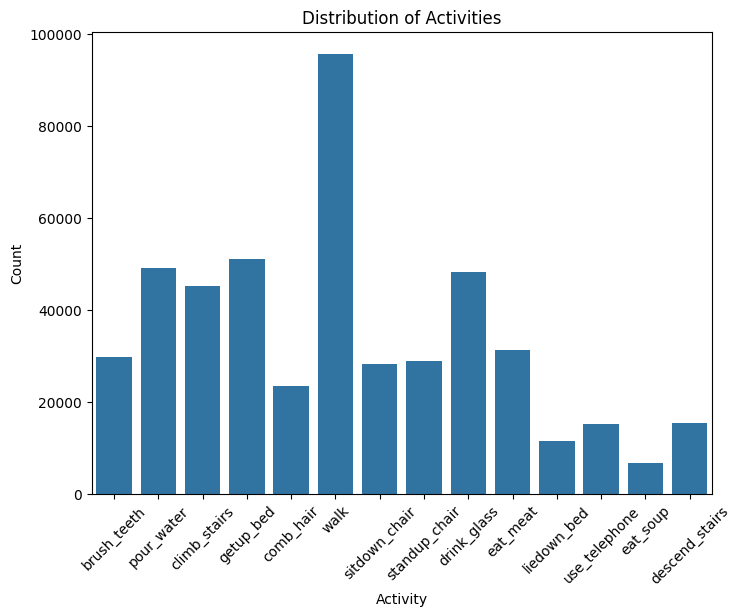

In [9]:
#Libraries for plotting
import seaborn as sns
from matplotlib import pyplot as plt

# Display the first few rows of the dataset
print(df.head())

# Check the shape of the dataset
print("Dataset shape:", df.shape)

# Summary statistics of the accelerometer data
print(df.describe())

# Plotting the distribution of activities
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Label')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.title('Distribution of Activities')
plt.xticks(rotation=45)
plt.show()




Let's now plot some accelerometer recordings for each activity. Try to find some differences

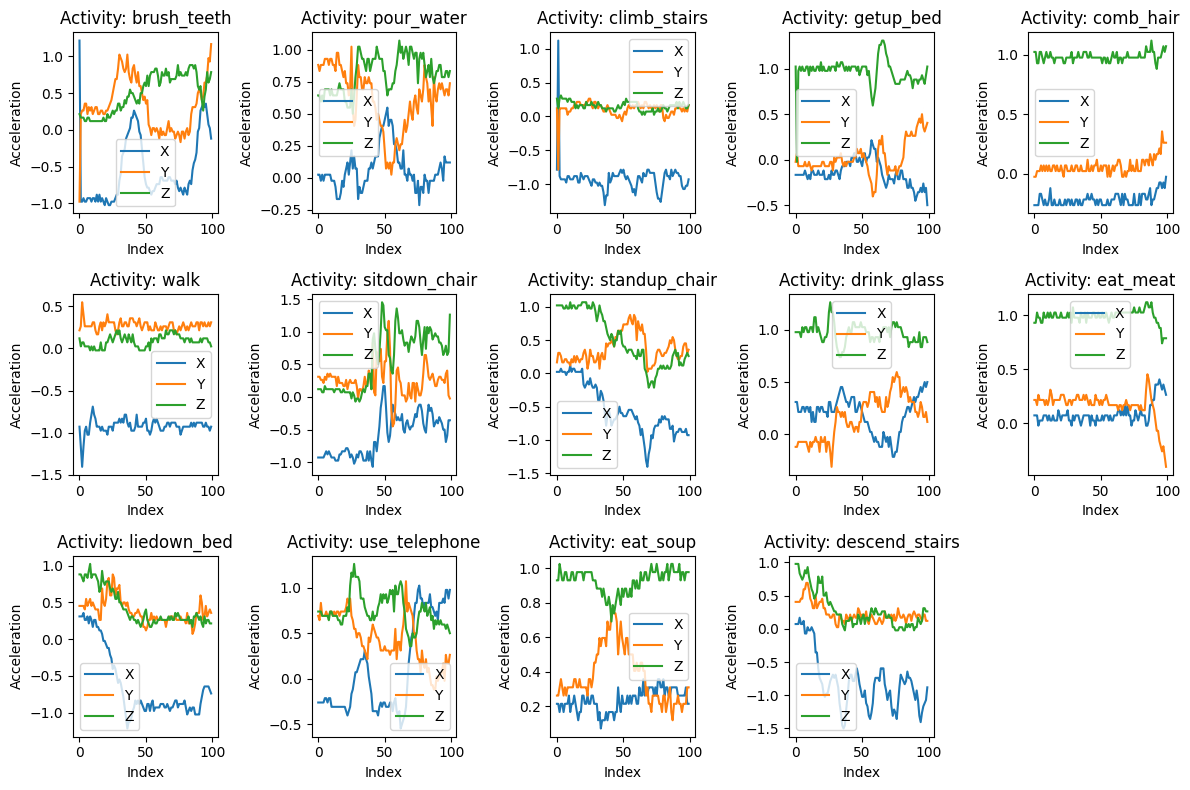

In [10]:
# Get a unique list of activity labels
activity_labels = df['Label'].unique()
num_samples = 100

# Plot one example of each activity
plt.figure(figsize=(12, 8))
for i, activity in enumerate(activity_labels):
    sample_recording = df[df['Label'] == activity].head(num_samples)  # Select the first 100 recordings for each activity
    plt.subplot(3, 5, i+1)
    sns.lineplot(data=sample_recording, x=sample_recording.index, y='X', label='X')
    sns.lineplot(data=sample_recording, x=sample_recording.index, y='Y', label='Y')
    sns.lineplot(data=sample_recording, x=sample_recording.index, y='Z', label='Z')
    plt.xlabel('Index')
    plt.ylabel('Acceleration')
    plt.title('Activity: {}'.format(activity))
    plt.legend()

plt.tight_layout()
plt.show()

We can also look at the magnitude instead of each axis separately. Let's see if you can find patterns more easily or not. Remember that the magnitude is orientation invariant meaning that it won't be affected by slight rotations of the sensor.

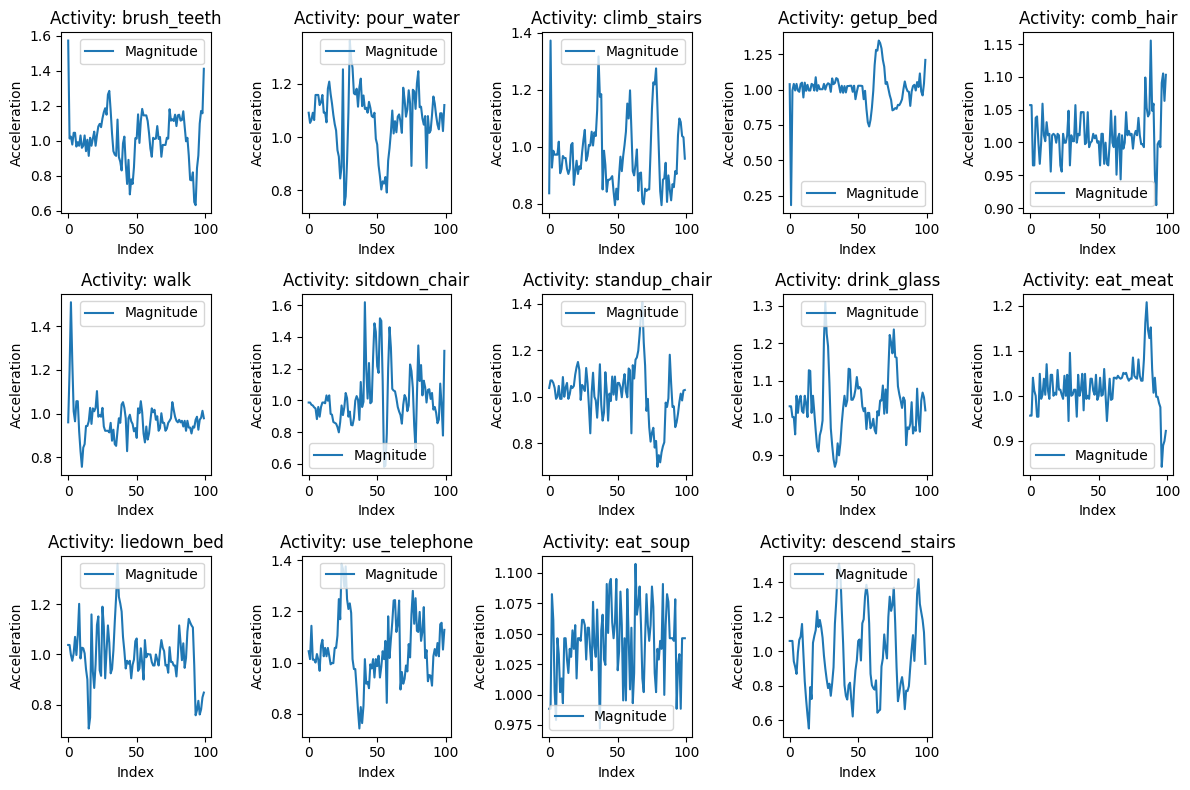

In [11]:
# Plot one example of each activity (magnitude)
plt.figure(figsize=(12, 8))

df['Magnitude'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)  #calculate the magnitude as the square root of the sum of squares. For square root use numpy's sqrt function. To get the square of x use x**2.
for i, activity in enumerate(activity_labels):
    sample_recording = df[df['Label'] == activity].head(num_samples)  # Select the first 100 recordings for each activity
    plt.subplot(3, 5, i+1)

    sns.lineplot(data=sample_recording, x=sample_recording.index, y='Magnitude', label='Magnitude')
    plt.xlabel('Index')
    plt.ylabel('Acceleration')
    plt.title('Activity: {}'.format(activity))
    plt.legend()

plt.tight_layout()
plt.show()

# Exploring the walking activity
Let's focus on walking for now. First, let's plot some examples of walking data.

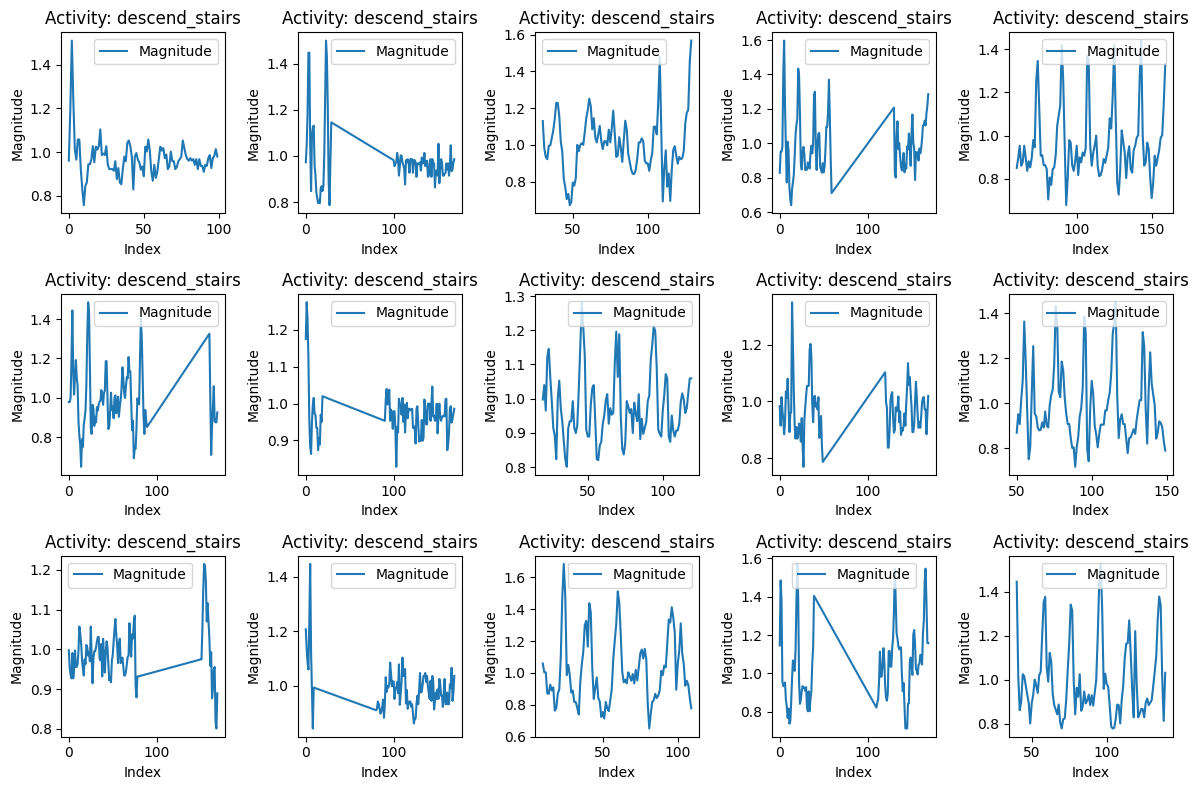

In [12]:
# Plot one example of each activity (magnitude)
plt.figure(figsize=(12, 8))

example_data = df[df.Label=='walk'] #filter data to get only walking data
for i in range(0, 15):
    sample_recording = example_data.iloc[i*100:i*100+100,:]  # Select the first 100 recordings for each activity
    plt.subplot(3, 5, i+1)

    sns.lineplot(data=sample_recording, x=sample_recording.index, y='Magnitude', label='Magnitude')
    plt.xlabel('Index')
    plt.ylabel('Magnitude')
    plt.title('Activity: {}'.format(activity))
    plt.legend()

plt.tight_layout()
plt.show()

Let's now see some statistics from  the walking records. Add comments to the code to describe what is happening in each line.


In [13]:
all_walking_recordings = df[df['Label'] == 'walk']


all_walking_recordings_groups = all_walking_recordings.groupby('id')

all_walking_recordings_groups.size().head(30)

id
266     170
267     170
268     170
269     170
270     170
271     170
272     170
273     170
274     170
275     170
276     170
277     170
278     170
279     170
280     170
281     170
282     170
283     170
284     170
285     170
612     534
613     913
614     915
615     906
616    1382
617    1857
618     943
619    1981
620     589
621     817
dtype: int64


**Question:** What are the following statistics about?

YOUR ANSWER GOES HERE IN TEXT

In [14]:
all_walking_recordings_groups.size().describe()

count     120.000000
mean      797.116667
std       455.294386
min       170.000000
25%       506.000000
50%       898.000000
75%       979.500000
max      3153.000000
dtype: float64

Let's find the average "walk" session


/tmp/ipykernel_12623/3951147441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_walking_recordings['timestep'] = all_walking_recordings.groupby('id').cumcount() + 1


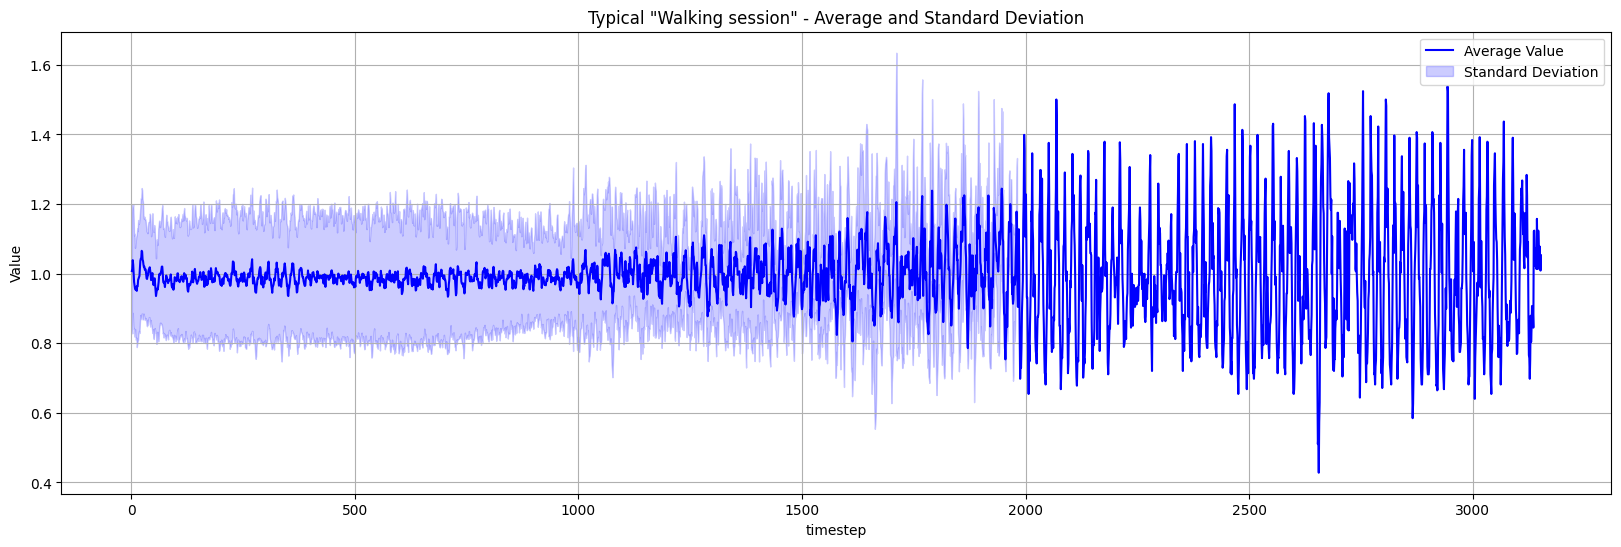

In [15]:
all_walking_recordings['timestep'] = all_walking_recordings.groupby('id').cumcount() + 1
# Group by hour and calculate average and standard deviation
walking_avg = all_walking_recordings.groupby('timestep')['Magnitude'].mean()
walking_std = all_walking_recordings.groupby('timestep')['Magnitude'].std()

# Create a DataFrame with the results
result_df = pd.DataFrame({'timestep': walking_avg.index, 'avg_value': walking_avg, 'std_value': walking_std})

# Calculate upper and lower bounds for standard deviation
result_df['upper'] = result_df['avg_value'] + result_df['std_value']
result_df['lower'] = result_df['avg_value'] - result_df['std_value']

# Create the plot
plt.figure(figsize=(20, 6))
plt.plot(result_df['timestep'], result_df['avg_value'], label='Average Value', color='blue')
plt.fill_between(result_df['timestep'], result_df['lower'], result_df['upper'], alpha=0.2, color='blue', label='Standard Deviation')

# Customize the plot (optional)
plt.xlabel('timestep')
plt.ylabel('Value')
plt.title('Typical "Walking session" - Average and Standard Deviation')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


/tmp/ipykernel_12623/379264985.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_recordings['timestep'] = all_recordings.groupby('id').cumcount() + 1
/tmp/ipykernel_12623/379264985.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_recordings['timestep'] = all_recordings.groupby('id').cumcount() + 1
/tmp/ipykernel_12623/379264985.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

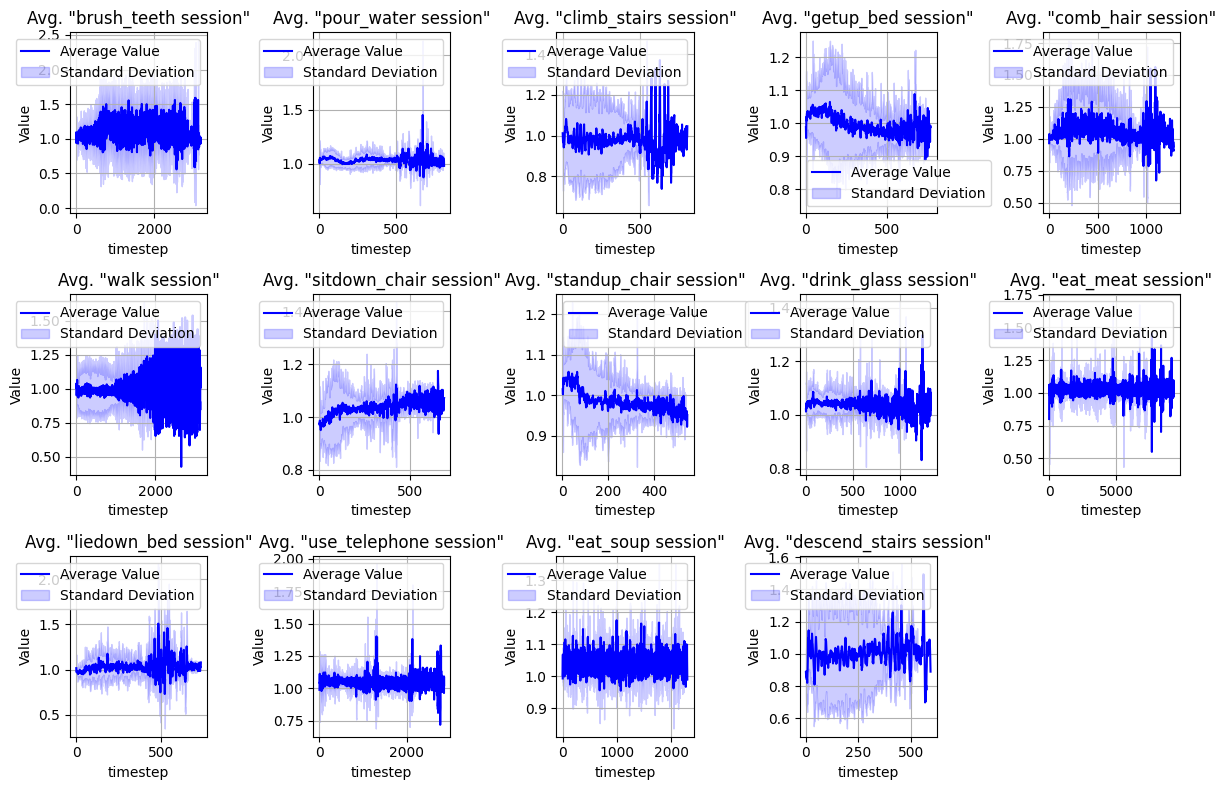

In [16]:
# Plot the average of each activity
plt.figure(figsize=(12, 8))

for i, activity in enumerate(activity_labels):
    all_recordings = df[df['Label'] == activity]
    all_recordings['timestep'] = all_recordings.groupby('id').cumcount() + 1
    # Group by hour and calculate average and standard deviation
    activity_avg = all_recordings.groupby('timestep')['Magnitude'].mean()
    activity_std = all_recordings.groupby('timestep')['Magnitude'].std()

    # Create a DataFrame with the results
    result_df = pd.DataFrame({'timestep': activity_avg.index, 'avg_value': activity_avg, 'std_value': activity_std})

    # Calculate upper and lower bounds for standard deviation
    result_df['upper'] = result_df['avg_value'] + result_df['std_value']
    result_df['lower'] = result_df['avg_value'] - result_df['std_value']

    # Create the plot
    plt.subplot(3, 5, i+1)
    plt.plot(result_df['timestep'], result_df['avg_value'], label='Average Value', color='blue')
    plt.fill_between(result_df['timestep'], result_df['lower'], result_df['upper'], alpha=0.2, color='blue', label='Standard Deviation')

    # Customize the plot (optional)
    plt.xlabel('timestep')
    plt.ylabel('Value')
    plt.title(f'Avg. "{activity} session"')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

### Statistical Summaries
Next, we compute statistical summaries for the accelerometer values of each activity. This provides insights into the central tendency, dispersion, and range of the data for different activities. The statistical summaries include the count, mean, standard deviation, minimum, 25th percentile, median, 75th percentile, and maximum values.

The statistical summaries enable us to compare and contrast the accelerometer values across different activities. We can observe variations in the magnitude and patterns of acceleration for each activity.

We group by activity label and use the describe function to get these summaries

In [17]:
# Group the data by activity and compute statistical summaries of X,Y and Z
activity_stats = df.groupby('Label')[['X', 'Y', 'Z']].describe()
print(activity_stats)

                      X                                                    \
                  count      mean       std       min       25%       50%   
Label                                                                       
brush_teeth     29829.0 -0.183124  0.501298 -1.500000 -0.452381 -0.214286   
climb_stairs    45258.0 -0.802304  0.384731 -1.500000 -0.976190 -0.880952   
comb_hair       23504.0  0.252206  0.592356 -1.404762 -0.071429  0.357143   
descend_stairs  15375.0 -0.716616  0.486804 -1.500000 -1.023810 -0.738095   
drink_glass     48192.0  0.212199  0.307319 -1.404762 -0.023810  0.214286   
eat_meat        31236.0  0.132849  0.128569 -0.357143  0.071429  0.119048   
eat_soup         6683.0  0.146409  0.104338 -0.214286  0.071429  0.166667   
getup_bed       51001.0 -0.423328  0.516996 -1.500000 -0.880952 -0.595238   
liedown_bed     11446.0 -0.361195  0.499489 -1.500000 -0.833333 -0.452381   
pour_water      48973.0 -0.018030  0.250220 -1.500000 -0.214286 -0.023810   

In [18]:
# Group the data by activity and compute statistical summaries of the Magnitude
activity_stats = df.groupby('Label')['Magnitude'].describe()
print(activity_stats)

                  count      mean       std       min       25%       50%  \
Label                                                                       
brush_teeth     29829.0  1.123799  0.355369  0.041239  0.950892  1.065593   
climb_stairs    45258.0  0.982851  0.203038  0.103783  0.850170  0.955649   
comb_hair       23504.0  1.075180  0.296604  0.041239  0.931619  1.028781   
descend_stairs  15375.0  0.993587  0.299980  0.103783  0.760042  0.972117   
drink_glass     48192.0  1.043391  0.059305  0.272512  1.013234  1.039743   
eat_meat        31236.0  1.022885  0.050133  0.194889  0.997446  1.026574   
eat_soup         6683.0  1.040464  0.045619  0.820306  1.013234  1.044096   
getup_bed       51001.0  1.008627  0.122690  0.140859  0.950892  1.001982   
liedown_bed     11446.0  1.022205  0.160677  0.103783  0.953273  1.008749   
pour_water      48973.0  1.034599  0.076711  0.078967  0.992889  1.030983   
sitdown_chair   28136.0  1.016328  0.109423  0.246288  0.969782  1.013234   

### Distribution Plot
To visualize the distribution of accelerometer values for each activity, we create a seaborn distribution plot. This plot displays the density estimation of the accelerometer values along the X, Y, and Z axes, with each activity represented by a different color. The plot provides an overview of the distribution patterns and helps identify any significant differences or similarities between activities.

By examining the distribution plot, we can understand the range and shape of the accelerometer values for each activity. This information is valuable for recognizing patterns and detecting anomalies within the dataset.

/tmp/ipykernel_12623/2150944520.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Activity')


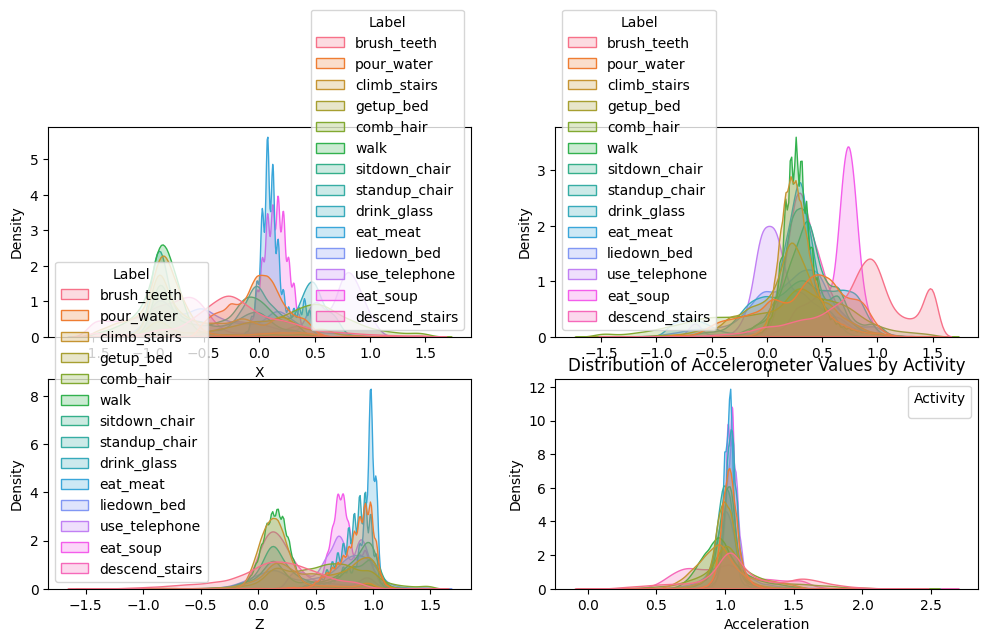

In [19]:
# Create a distribution plot for each activity
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.kdeplot(data=df, x='X', hue='Label', fill=True, common_norm=False)
plt.subplot(2, 2, 2)
sns.kdeplot(data=df, x='Y', hue='Label', fill=True, common_norm=False)
plt.subplot(2, 2, 3)
sns.kdeplot(data=df, x='Z', hue='Label', fill=True, common_norm=False)
plt.subplot(2, 2, 4)
sns.kdeplot(data=df, x='Magnitude', hue='Label', fill=True, common_norm=False)
plt.xlabel('Acceleration')
plt.ylabel('Density')
plt.title('Distribution of Accelerometer Values by Activity')
plt.legend(title='Activity')
plt.show()

## Activity 1
After exploring the dataset, answer the following questions


1. What are the activities included in the accelerometer dataset?
2. Can you describe the characteristics of each activity based on the sample recordings?
3. How do the accelerometer values differ across different activities? Are there any noticeable patterns or trends?
4. What insights can you gather from the statistical summaries of the accelerometer values for each activity?
5. Are there any significant differences in the distribution of accelerometer values between activities? If so, what are they?
6. Can you identify any outliers or anomalies in the accelerometer data? How might these affect the analysis or interpretation of the results? You might need to create additional plots for this question.
7. How could the findings from the EDA be useful in developing an activity recognition model or application?
9. How might the EDA findings be relevant in real-world scenarios, such as developing activity monitoring systems or fitness applications?

# Obtaining features
We are now ready to extract our features.
We will use the tsfresh library for this. Run the following command to install it


In [20]:
#Install tsfresh library to extract features
!pip install tsfresh

tsfresh will extract features for each entity. An entity can be a time window, a volunteer, a sensor or the unit that you define to make each sample for your classification model. We will use each file in the dataset as a unit. This is the column id

We also need to have the true labels for each sample. We will use the y array for this.

Finally, we extract the volunteer to be able to do leave-one-subject

In [21]:
from tsfresh import extract_features
from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import roll_time_series

#Prepare data for tsfresh. It needs an id column for each window. We will use each file as one window so the if is the same as the dataframe id.

#we only need time, label and accelerometer values
data = df[['X','Y','Z','id', 'Label']]

# Prepare labels by keeping only one label per file (i.e. remove the duplicates for each file)
y = data[['Label','id']].copy()
y = y.set_axis(y.id)
labels = y.drop_duplicates()
labels = labels['Label']

print(labels.shape)

data = data.drop('Label', axis=1)
print(data.head())

(979,)
          X         Y         Z  id
0  1.214286 -0.976190  0.214286   0
1 -0.976190  0.214286  0.166667   0
2 -0.976190  0.261905  0.166667   0
3 -0.928571  0.261905  0.166667   0
4 -0.976190  0.357143  0.119048   0


In [22]:
# Specify which features you want to extract, and parameters for each of them
feature_parameters = {
    'mean': None,
    'large_standard_deviation': [{'r':0.3}],
    'standard_deviation':None,
    'minimum': None,
    'maximum': None,
    'kurtosis': None,
    'skewness': None
}

# Apply feature extraction using the tsfresh method
extracted_features = extract_features(
    data,
    column_id='id',
    default_fc_parameters=feature_parameters,
    kind_to_fc_parameters={'': feature_parameters},
    disable_progressbar=False
)

# Display the extracted features
print(extracted_features.shape)

Feature Extraction:   0%|          | 0/80 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 80/80 [00:00<00:00, 952.52it/s]

(979, 21)


In [23]:
extracted_features.head()


,X__mean,X__large_standard_deviation__r_0.3,X__standard_deviation,X__minimum,X__maximum,X__kurtosis,X__skewness,Y__mean,Y__large_standard_deviation__r_0.3,Y__standard_deviation,...,Y__maximum,Y__kurtosis,Y__skewness,Z__mean,Z__large_standard_deviation__r_0.3,Z__standard_deviation,Z__minimum,Z__maximum,Z__kurtosis,Z__skewness
0,-0.295823,0.0,0.479464,-1.5,1.500000,1.827834,0.405540,0.796168,0.0,0.470216,...,1.5,-0.089300,-0.497537,0.119149,0.0,0.428196,-1.452381,1.452381,0.131058,-0.396589
1,-0.267332,0.0,0.501093,-1.5,1.452381,1.340287,0.362606,0.815404,0.0,0.462489,...,1.5,0.244676,-0.646171,0.107861,0.0,0.434036,-1.261905,1.452381,0.099641,-0.254139
2,0.193059,0.0,0.552970,-1.5,1.500000,-0.143477,0.223633,0.832768,0.0,0.374065,...,1.5,0.804923,-0.710035,0.314004,0.0,0.265310,-0.500000,1.404762,0.083119,0.363488
3,-0.083933,0.0,0.444673,-1.5,1.500000,1.768781,0.130527,0.898190,0.0,0.416633,...,1.5,1.012812,-0.917647,0.081335,0.0,0.462007,-1.357143,1.166667,0.103836,-0.482845
4,-0.295428,0.0,0.460746,-1.5,1.357143,1.337617,0.140122,0.839198,0.0,0.454482,...,1.5,0.804083,-0.775862,0.101025,0.0,0.389127,-1.166667,1.119048,0.172273,-0.382651


We are using only some features (specified in the feature_parameters).

You could use the following code to extract all features available (over 1000)



```
Extract features from the rolled data using tsfresh

extracted_features = extract_relevant_features(data, y, column_id='id')
```

Let's save the extracted features



In [24]:
extracted_features.to_csv('adl_features.csv')

## Building the model
We are finally ready to build our activity recognition model. Since this is a classification problem, we can use any classification algorithm.

We will use scikit-learn, a comprehensive machine learning library that provides various algorithms, evaluation metrics, and data preprocessing techniques.

In this example, we will use the following models:

*Support Vector Machine (SVM):* SVM is a powerful supervised learning algorithm used for classification tasks. It aims to find an optimal hyperplane that separates different classes by maximizing the margin between them.

*Decision Tree:* Decision trees are hierarchical models that make decisions by partitioning the feature space into smaller regions based on the available features. These models are intuitive, interpretable, and capable of handling both numerical and categorical data.

To evaluate the models, we will use **Leave-one-group-out cross-validation** which is a technique used to evaluate the performance of a model when dealing with grouped or clustered data. It ensures that each group (in our case, each volunteer) is left out once as the validation set, while the remaining groups are used for training.

This method helps assess the model's generalization ability by simulating real-world scenarios where unseen groups (volunteers) are encountered during inference. This also ensures that we do not have any **data leakage** during training.

Let's first create a list of the volunteers corresponding to each id (file)

In [25]:
group = df[['id', 'Volunteer']]
group = group.drop_duplicates()
group = group.set_index('id')
group = group['Volunteer']
group.shape

(979,)

In [26]:
X = extracted_features
X.shape

(979, 21)

In [27]:
labels.head()

id
0    brush_teeth
1    brush_teeth
2    brush_teeth
3    brush_teeth
4    brush_teeth
Name: Label, dtype: object

In [28]:
labels.shape

(979,)

In [29]:
#check consistency
assert(X.shape[0] == labels.shape[0])

In [30]:
tabular_data = X.copy()
tabular_data['label'] = labels
tabular_data.head()

,X__mean,X__large_standard_deviation__r_0.3,X__standard_deviation,X__minimum,X__maximum,X__kurtosis,X__skewness,Y__mean,Y__large_standard_deviation__r_0.3,Y__standard_deviation,...,Y__kurtosis,Y__skewness,Z__mean,Z__large_standard_deviation__r_0.3,Z__standard_deviation,Z__minimum,Z__maximum,Z__kurtosis,Z__skewness,label
0,-0.295823,0.0,0.479464,-1.5,1.500000,1.827834,0.405540,0.796168,0.0,0.470216,...,-0.089300,-0.497537,0.119149,0.0,0.428196,-1.452381,1.452381,0.131058,-0.396589,brush_teeth
1,-0.267332,0.0,0.501093,-1.5,1.452381,1.340287,0.362606,0.815404,0.0,0.462489,...,0.244676,-0.646171,0.107861,0.0,0.434036,-1.261905,1.452381,0.099641,-0.254139,brush_teeth
2,0.193059,0.0,0.552970,-1.5,1.500000,-0.143477,0.223633,0.832768,0.0,0.374065,...,0.804923,-0.710035,0.314004,0.0,0.265310,-0.500000,1.404762,0.083119,0.363488,brush_teeth
3,-0.083933,0.0,0.444673,-1.5,1.500000,1.768781,0.130527,0.898190,0.0,0.416633,...,1.012812,-0.917647,0.081335,0.0,0.462007,-1.357143,1.166667,0.103836,-0.482845,brush_teeth
4,-0.295428,0.0,0.460746,-1.5,1.357143,1.337617,0.140122,0.839198,0.0,0.454482,...,0.804083,-0.775862,0.101025,0.0,0.389127,-1.166667,1.119048,0.172273,-0.382651,brush_teeth


We will now build the model following these steps

*Data Preparation:* The feature matrix 'X' and target vector 'y' should be prepared before running the code. Ensure that the 'volunteer' column is available in the dataset.

*Cross-Validation Loop: *The model utilizes the LeaveOneGroupOut cross-validator provided by scikit-learn. It splits the data into training and testing sets, ensuring that each volunteer is left out once as the validation set.

*Feature Scaling: *Before fitting the models, the feature matrix is standardized using the StandardScaler from scikit-learn. This ensures that all features have similar scales and prevents any particular feature from dominating the learning process.

*Model Fitting and Prediction:* The SVM and Decision Tree models are trained on the scaled training data using the **fit() **method. The trained models are then used to predict the labels for the scaled test data using the predict() method.

*Classification Reports:* After the cross-validation loop, the overall classification reports are computed using the true labels and predictions from all the folds. These reports provide important metrics such as precision, recall, and F1-score for each class, as well as an overall accuracy score.

In [31]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler

def train_and_classify(X, y, group):

  # Initialize SVM and Decision Tree classifiers
  svm_model = SVC()
  dt_model = DecisionTreeClassifier()

  # Create empty lists to accumulate predictions and true labels
  svm_predictions = []
  dt_predictions = []
  true_labels = []

  # Create the LeaveOneGroupOut cross-validator based on 'Volunteer' column
  logo = LeaveOneGroupOut()

  n_groups = logo.get_n_splits(X, y, groups=group)

  # Perform leave-one-subject-out cross-validation
  for train_index, test_index in tqdm(logo.split(X, y, groups=group), total=n_groups):
      # Split the data into training and testing sets
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # Create a scaler to standardize the features
      scaler = StandardScaler()

      # Standardize the feature matrix for training set. Notice that if we scale before separating, we are having a data leakage.
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)

      # Fit the SVM model on the training data
      svm_model.fit(X_train_scaled, y_train)

      # Predict the labels for the test data using SVM model
      svm_pred = svm_model.predict(X_test_scaled)

      # Accumulate the predictions and true labels
      svm_predictions.extend(svm_pred)
      true_labels.extend(y_test)

      # Fit the Decision Tree model on the training data
      dt_model.fit(X_train_scaled, y_train)

      # Predict the labels for the test data using Decision Tree model
      dt_pred = dt_model.predict(X_test_scaled)

      # Accumulate the predictions
      dt_predictions.extend(dt_pred)

  # Print the overall classification report for SVM model
  print("SVM Classification Report:")
  print(classification_report(true_labels, svm_predictions))

  # Print the overall classification report for Decision Tree model
  print("Decision Tree Classification Report:")
  print(classification_report(true_labels, dt_predictions))


In [32]:
train_and_classify(X.values, labels, group)

100%|██████████| 27/27 [00:00<00:00, 56.83it/s]

SVM Classification Report:
                precision    recall  f1-score   support

   brush_teeth       1.00      0.17      0.29        12
  climb_stairs       0.46      0.43      0.44       122
     comb_hair       0.87      0.84      0.85        31
descend_stairs       0.44      0.10      0.16        42
   drink_glass       0.62      0.53      0.57       120
      eat_meat       0.00      0.00      0.00         5
      eat_soup       0.00      0.00      0.00         3
     getup_bed       0.52      0.69      0.60       121
   liedown_bed       0.00      0.00      0.00        28
    pour_water       0.56      0.76      0.65       120
 sitdown_chair       0.66      0.69      0.68       120
 standup_chair       0.66      0.72      0.69       122
 use_telephone       1.00      0.08      0.14        13
          walk       0.50      0.60      0.55       120

      accuracy                           0.58       979
     macro avg       0.52      0.40      0.40       979
  weighted avg     


/home/odin/miniconda3/envs/lerobot/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/odin/miniconda3/envs/lerobot/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/odin/miniconda3/envs/lerobot/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

# Using sliding windows
In activity recognition, the sliding window technique plays a pivotal role by breaking down continuous sensor data into smaller segments. This enables the model to capture temporal patterns, ensuring a more comprehensive understanding of dynamic activities over time.

A sliding window is a technique used in signal processing and time-series analysis. It involves moving a fixed-size window through a dataset, capturing a subset of the data within the window at each step. In the following illustration, the sliding window of size 4 moves one step at a time through the time series data, capturing a subset of four data points at each position. This process allows the model to analyze sequential patterns and relationships in the data.

Original Time Series Data:
```
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
```

Sliding Window (size = 4):

```
|---|---|---|---|
1   2   3   4

  |---|---|---|---|
  2   3   4   5

    |---|---|---|---|
    3   4   5   6

      |---|---|---|---|
      4   5   6   7

        |---|---|---|---|
        5   6   7   8

          |---|---|---|---|
          6   7   8   9

            |---|---|---|---|
            7   8   9   10

```




The following functions will create the windows. The line that does the windows is
```
strided = as_strided(a,shape = newshape,strides = newstrides)
```
This is a function from numpy. Read the documentation and explain what this function does.

In [33]:
#code from https://github.com/ubicompsoartutorial/soar_tutorial/blob/main/ecdf/sliding_window.py
import numpy as np
from numpy.lib.stride_tricks import as_strided as ast

def norm_shape(shape):
    '''
    Normalize numpy array shapes so they're always expressed as a tuple,
    even for one-dimensional shapes.

    Parameters
        shape - an int, or a tuple of ints

    Returns
        a shape tuple
    '''
    try:
        i = int(shape)
        return (i,)
    except TypeError:
        # shape was not a number
        pass

    try:
        t = tuple(shape)
        return t
    except TypeError:
        # shape was not iterable
        pass

    raise TypeError('shape must be an int, or a tuple of ints')

def sliding_window(a,ws,ss = None,flatten = True):
    '''
    Return a sliding window over a in any number of dimensions

    Parameters:
        a  - an n-dimensional numpy array
        ws - an int (a is 1D) or tuple (a is 2D or greater) representing the size
             of each dimension of the window
        ss - an int (a is 1D) or tuple (a is 2D or greater) representing the
             amount to slide the window in each dimension. If not specified, it
             defaults to ws.
        flatten - if True, all slices are flattened, otherwise, there is an
                  extra dimension for each dimension of the input.

    Returns
        an array containing each n-dimensional window from a
    '''

    if None is ss:
        # ss was not provided. the windows will not overlap in any direction.
        ss = ws
    ws = norm_shape(ws)
    ss = norm_shape(ss)

    # convert ws, ss, and a.shape to numpy arrays so that we can do math in every
    # dimension at once.
    ws = np.array(ws)
    ss = np.array(ss)
    shape = np.array(a.shape)

    # ensure that ws, ss, and a.shape all have the same number of dimensions
    ls = [len(shape),len(ws),len(ss)]
    if 1 != len(set(ls)):
        raise ValueError(\
        'a.shape, ws and ss must all have the same length. They were %s' % str(ls))

    # ensure that ws is smaller than a in every dimension
    if np.any(ws > shape):
        raise ValueError(\
        'ws cannot be larger than a in any dimension.\
        a.shape was %s and ws was %s' % (str(a.shape),str(ws)))

    # how many slices will there be in each dimension?
    newshape = norm_shape(((shape - ws) // ss) + 1)
    # the shape of the strided array will be the number of slices in each dimension
    # plus the shape of the window (tuple addition)
    newshape += norm_shape(ws)
    # the strides tuple will be the array's strides multiplied by step size, plus
    # the array's strides (tuple addition)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides
    strided = ast(a,shape = newshape,strides = newstrides)
    if not flatten:
        return strided

    # Collapse strided so that it has one more dimension than the window.  I.e.,
    # the new array is a flat list of slices.
    meat = len(ws) if ws.shape else 0
    firstdim = (np.prod(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])
    # remove any dimensions with size 1
    # dim = filter(lambda i : i != 1,dim)
    return strided.reshape(dim)

In [34]:
def perform_sliding_window(data_x,
                           data_y,
                           ws,
                           ss):
    """
    Efficiently performing the sliding window based segmentation
    :param data_x: processed data stream
    :param data_y: processed labels stream
    :param ws: window size
    :param ss: overlap size
    :return: windowed data and ground truth labels
    """
    data_x = sliding_window(data_x, (ws, data_x.shape[1]), (ss, 1))

    # Just making it a vector if it was a 2D matrix
    data_y = np.reshape(data_y, (len(data_y),))
    data_y = np.asarray([[i[-1]] for i in sliding_window(data_y, ws, ss)])
    return data_x.astype(np.float32), data_y.reshape(len(data_y)). \
        astype(np.uint8)

Run the following line to understand the code. Input parameters are the accelerometer data (a 2D matrix) and the activity labels.

In [35]:
# Create a 2D matrix of size 20x3 with random numbers between 0 and 100
random_x = np.random.randint(0, 101, size=(20, 3))

# Create a vector of size 20 with random integers between 0 and 3
random_y = np.random.randint(0, 4, size=20)

print(random_x)

print("Windows")

win_x, win_y = perform_sliding_window(random_x, random_y, 10, 5)
print(win_x)

[[99 56 43]
 [36 56  4]
 [42 35 67]
 [98 27 54]
 [87 70 17]
 [73 42 86]
 [ 4 24 48]
 [94 58 10]
 [16 34 43]
 [51  3 87]
 [97 58 72]
 [52 74 21]
 [61 84 79]
 [ 9 79 28]
 [67 58 80]
 [21 19 26]
 [69 12 20]
 [58 73 50]
 [43  1 29]
 [71  2 12]]
Windows
[[[99. 56. 43.]
  [36. 56.  4.]
  [42. 35. 67.]
  [98. 27. 54.]
  [87. 70. 17.]
  [73. 42. 86.]
  [ 4. 24. 48.]
  [94. 58. 10.]
  [16. 34. 43.]
  [51.  3. 87.]]

 [[73. 42. 86.]
  [ 4. 24. 48.]
  [94. 58. 10.]
  [16. 34. 43.]
  [51.  3. 87.]
  [97. 58. 72.]
  [52. 74. 21.]
  [61. 84. 79.]
  [ 9. 79. 28.]
  [67. 58. 80.]]

 [[97. 58. 72.]
  [52. 74. 21.]
  [61. 84. 79.]
  [ 9. 79. 28.]
  [67. 58. 80.]
  [21. 19. 26.]
  [69. 12. 20.]
  [58. 73. 50.]
  [43.  1. 29.]
  [71.  2. 12.]]]


/tmp/ipykernel_12623/255113360.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(shape)


## Questions
1. What is the size of the original data (random_x)?
2. What is the size of each window?
3. What is the shape of the result (win_x) ?
4. What line is the beginning of the second window?
5. What is the meaning of the overlap parameter (ss)?





Let's now create some windows for the dataset. For each window, we will obtain the features we calculated before (mean, median, mode ... ). Each window will now become one sample for the classifier.

In [36]:
WINDOW_SIZE = 30  # 1 second of data
OVERLAP = 15  # 50% overlap, as is typical

In [37]:
from scipy.stats import mode

def feature_representation(x):
  #assert what is the expected shape of x?
  assert x.shape[0] == WINDOW_SIZE

  # Calculate statistical features
  mean_values = np.mean(x, axis=0)
  mode_values = mode(x, axis=0).mode

  median_values = np.median(x, axis=0)

  max_values = np.max(x, axis=0)
  min_values = np.min(x, axis=0)
  q75, q25 = np.percentile(x, [75, 25], axis=0)
  iqr_values = q75 - q25

  # Concatenate all the values into a single array
  features = np.concatenate([mean_values, mode_values, median_values, max_values, min_values, iqr_values])

  # Return the results
  return features

def get_features(x):
  num_windows = x.shape[0]
  num_components = x.shape[2]
  temp_features = np.zeros((num_windows, (num_components) * 6))

  # Compute features for each windows using feature_representation
  for i in range(num_windows):
    temp_features[i] = feature_representation(x[i])

  # Return values
  return temp_features

In [38]:
data = df[['X','Y','Z', 'Label', 'Volunteer']]

#encode labels - convert them to numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = df['Label'].values
le.fit(y)

labels = le.transform(y)

In [39]:
print(data.shape)
print(labels.shape)
print(group.shape)

(479289, 5)
(479289,)
(979,)


In [40]:
#get sliding window and features per user
users = df['Volunteer'].unique()
user_le = LabelEncoder()
user_le.fit(users)
users_num = user_le.transform(users)

all_data = []
all_labels = []
all_groups = []
for i in tqdm(range(len(users))):
  user_data = data[data['Volunteer']==users[i]]
  x = user_data[['X', 'Y', 'Z']].values
  y = user_data['Label'].values
  y = le.transform(y)
  win_x, win_y = perform_sliding_window(
              x,
              y,
              WINDOW_SIZE,
              OVERLAP
          )
  #get features
  features = get_features(win_x)
  all_data.append(features)
  all_labels.append(win_y)

  groups = np.full_like(win_y, fill_value=users_num[i])
  all_groups.append(groups)

#train and classify with the new windows
X = np.concatenate(all_data)
y = np.concatenate(all_labels)
groups = np.concatenate(all_groups)

  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_12623/255113360.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(shape)
  4%|▎         | 1/27 [00:02<01:17,  2.99s/it]/tmp/ipykernel_12623/255113360.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(shape)
  7%|▋         | 2/27 [00:03<00:41,  1.64s/it]/tmp/ipykernel_12623/255113360.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(shape)
 11%|█         | 3/27 [00:04<00:26,  1.09s/it]/tmp/ipykernel_12623/255113360.py:

In [41]:
assert X.shape[0] == y.shape[0] == groups.shape[0]

print(X)

[[-0.88095248  0.29841271  0.16666667 ...  0.04761904  0.13095238
   0.08333334]
 [-0.52222222  0.61587304  0.29841274 ...  0.94047616  0.51190473
   0.22619048]
 [-0.35714287  0.52539682  0.5365079  ...  0.7142857   0.6785714
   0.30952379]
 ...
 [-0.44444451  0.41111118  0.78730178 ...  0.08333333  0.08333333
   0.        ]
 [-0.45873019  0.42063496  0.79047626 ...  0.04761904  0.04761904
   0.        ]
 [-0.45555559  0.42539686  0.78730178 ...  0.03571428  0.04761904
   0.        ]]


In [42]:
train_and_classify(X,y, groups)

100%|██████████| 27/27 [02:32<00:00,  5.65s/it]

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.54      0.62      1984
           1       0.23      0.08      0.12      3011
           2       0.67      0.45      0.54      1567
           3       0.45      0.18      0.26      1024
           4       0.48      0.59      0.53      3212
           5       0.00      0.00      0.00      2083
           6       0.00      0.00      0.00       446
           7       0.30      0.47      0.37      3395
           8       0.06      0.00      0.01       763
           9       0.32      0.67      0.43      3259
          10       0.23      0.07      0.11      1874
          11       0.22      0.10      0.13      1919
          12       0.69      0.21      0.32      1014
          13       0.58      0.82      0.68      6364

    accuracy                           0.43     31915
   macro avg       0.35      0.30      0.29     31915
weighted avg       0.39      0.43      0.38     31915

# Homework

1. We didn't filter the signal. Include a filter and see if the classification performance improves.

2. Sliding windows can have different sizes.
Make experiments to evaluate which window size has better performance. Select 3 window sizes and provide recommendations based on the type of activity, number of examples, etc.

[OPTIONAL] : Try different classifiers. Random Forest and XGBoost tend to have improved performance.

